# EE5179 - Assignment-2
___
 1. Name: Sapna R
 2. Roll No: BS20B032

# Part 1

In [ ]:
import torch
import torch.nn as nn
#import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import torchvision.datasets as datasets
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

In [2]:
def sigmoid(x):
    return 1/(1+np.exp(-x))
def relu(x):
    x[np.where(x<0)]=0
    return x
def softmax(z):
    return np.exp(z)/np.sum(np.exp(z))
def tanh(x):
    return (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))

In [3]:
def sigmoid_prime(x):
    return np.multiply(x,1-x)
def relu_prime(x):
    x[np.where(x>=0)]=1
    x[np.where(x<0)]=0
    return x
def tanh_prime(x):
    return 1-np.square(x)

In [4]:
activation_map={'sigmoid':sigmoid,'relu':relu,'tanh':tanh}
activation_der={'sigmoid':sigmoid_prime,'relu':relu_prime,'tanh':tanh_prime}

In [5]:
train_data=datasets.MNIST(root='./',train=True,download=True)
test_data=datasets.MNIST(root='./',train=False,download=True)

In [6]:
X_train=np.zeros((len(train_data),28,28))
y_train=np.zeros((len(train_data),10))


In [7]:
for i in range(len(train_data)):
    X_train[i]=np.array(list(train_data.__getitem__(i))[0])
    y_train[i][list(train_data.__getitem__(i))[1]]=1

In [8]:
X_test=np.zeros((len(test_data),28,28))
y_test=np.zeros((len(test_data),10))

In [9]:
for i in range(len(test_data)):
    X_test[i]=np.array(list(test_data.__getitem__(i))[0])
    y_test[i][list(test_data.__getitem__(i))[1]]=1

In [10]:
X_train=(X_train/255)
X_test=X_test/255

In [11]:
X_train.shape

(60000, 28, 28)

In [12]:
X_train=np.expand_dims(X_train,axis=1)
X_test=np.expand_dims(X_test,axis=1)

In [13]:
class MyConvNet(nn.Module):
    def __init__(self,input_channel=1,num_channels=32,conv_stride=1,conv_padding=1,conv_kernel=(3,3),pool_stride=2,pool_pad=0,pool_kernel=(2,2),fc1_neurons=500,fc2_neurons=10,device='cpu'):
        super(MyConvNet,self).__init__()
        self.conv1=nn.Conv2d(in_channels=input_channel,out_channels=num_channels,kernel_size=conv_kernel,stride=conv_stride,padding=conv_padding)
        self.relu1=nn.ReLU()
        self.max_pool1=nn.MaxPool2d(kernel_size=pool_kernel,stride=pool_stride,padding=pool_pad)
        self.conv2=nn.Conv2d(in_channels=num_channels,out_channels=num_channels,kernel_size=conv_kernel,stride=conv_stride,padding=conv_padding)
        self.relu2=nn.ReLU()
        self.max_pool2=nn.MaxPool2d(kernel_size=pool_kernel,stride=pool_stride,padding=pool_pad)
        self.fc1_neurons=fc1_neurons
        self.fc1=None
        self.fc2_neurons=fc2_neurons
        self.relu3=nn.ReLU()
        self.fc2=nn.Linear(fc1_neurons,fc2_neurons)
        self.sm=nn.Softmax(dim=1)
    def forward(self,x):
        out1=self.relu1(self.conv1(x)).to(device)
        out1_1=self.max_pool1(out1).to(device)
        out2=self.relu2(self.conv2(out1_1)).to(device)
        out2_1=self.max_pool2(out2).to(device)
        if self.fc1  is None:
            self.fc1=nn.Linear(torch.flatten(out2_1,1).shape[1],self.fc1_neurons).to(device)
        #print(self.fc1.weight.device)
        #print(torch.flatten(out2_1,1).device)
        out3=self.relu3(self.fc1(torch.flatten(out2_1,1)).to(device))
        out4=self.fc2(out3).to(device)
        softmax_out=self.sm(out4).to(device)

        return out4




In [14]:
"""def accuracy(y_pred,y_truth):
    return (1-(np.count_nonzero(np.argmax(y_pred,axis=1)-np.argmax(y_truth,axis=1)))/(y_pred.shape[0]))*100"""


'def accuracy(y_pred,y_truth):\n    return (1-(np.count_nonzero(np.argmax(y_pred,axis=1)-np.argmax(y_truth,axis=1)))/(y_pred.shape[0]))*100'

In [15]:
def eval(model,X,y,criterion,batchsize=1000):

  model.eval()
  loss=0.0
  correct_samples=0.0
  dataset=TensorDataset(X,y)
  dataloader=DataLoader(dataset,batch_size=batchsize,shuffle=False)
  for batch_X,batch_y in dataloader:
    with torch.no_grad():
      output=model(batch_X)
      loss+=(criterion(output,batch_y).item())*batch_X.shape[0]
      correct_samples+=torch.sum(torch.argmax(output,dim=1)==torch.argmax(batch_y,dim=1)).item()
  loss/=X.shape[0]
  accuracy=(correct_samples/X.shape[0])*100
  return [loss,accuracy]


In [16]:
def train_model(model, X_train,y_train,X_val,y_val, criterion, optimizer, num_epochs=10, device='cpu'):
    X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
    X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
    y_train=torch.tensor(y_train,dtype=torch.float32).to(device)
    y_val=torch.tensor(y_val,dtype=torch.float32).to(device)
    #print(X_train.device)
    batch_size = 64
    dataset = TensorDataset(X_train, y_train)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    model.train()
    """for module in model.modules():
        if isinstance(module, torch.nn.BatchNorm2d) or isinstance(module, torch.nn.BatchNorm1d):
            module.eval()"""
    train_error=[]
    val_error=[]
    train_accuracy=[]
    val_accuracy=[]
    [train_loss,train_acc]=eval(model,X_train,y_train,criterion)
    [val_loss,val_acc]=eval(model,X_val,y_val,criterion)

    train_accuracy.append(train_acc)
    train_error.append(train_loss)
    val_error.append(val_loss)
    val_accuracy.append(val_acc)
    updates=0
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in dataloader:
            #print(train_loss)
            # Zero the parameter gradients
            updates+=1
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            if updates%200==0:
              [train_loss,train_acc]=eval(model,X_train,y_train,criterion)
              [val_loss,val_acc]=eval(model,X_val,y_val,criterion)

              train_accuracy.append(train_acc)
              train_error.append(train_loss)
              val_error.append(val_loss)
              val_accuracy.append(val_acc)
        """train_output = model(X_train.to(device))
        train_loss = criterion(train_output,y_train)
        train_error.append(train_loss.item())

        val_output=model(X_val)
        val_loss=criterion(val_output,y_val)
        val_error.append(val_loss.item())"""






        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}')

    print('Training complete.')
    return [model,train_error,val_error,train_accuracy,val_accuracy]



In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

"""X_train=torch.tensor(X_train,dtype=torch.float32).to(device)
y_train=torch.tensor(y_train,dtype=torch.float32).to(device)
X_test=torch.tensor(X_test,dtype=torch.float32).to(device)
y_test=torch.tensor(y_test,dtype=torch.float32).to(device)"""
#print(X_train.device)

'X_train=torch.tensor(X_train,dtype=torch.float32).to(device)\ny_train=torch.tensor(y_train,dtype=torch.float32).to(device)\nX_test=torch.tensor(X_test,dtype=torch.float32).to(device)\ny_test=torch.tensor(y_test,dtype=torch.float32).to(device)'

In [18]:
batch_size = 64
learning_rate = 0.01
num_epochs = 15
print(device)
model = MyConvNet(device=device).to(device)
criterion = nn.CrossEntropyLoss()
print(model.parameters())
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


[model,train_error,val_error,train_accuracy,val_accuracy]=train_model(model, X_train[:50000],y_train[:50000], X_train[50000:],y_train[50000:],criterion, optimizer, num_epochs=num_epochs, device=device)

cpu
<generator object Module.parameters at 0x000001ED0618EDC0>
Epoch [1/15], Loss: 0.1701
Epoch [2/15], Loss: 0.0691
Epoch [3/15], Loss: 0.0559
Epoch [4/15], Loss: 0.0489
Epoch [5/15], Loss: 0.0430
Epoch [6/15], Loss: 0.0417
Epoch [7/15], Loss: 0.0363
Epoch [8/15], Loss: 0.0363
Epoch [9/15], Loss: 0.0326
Epoch [10/15], Loss: 0.0369
Epoch [11/15], Loss: 0.0275
Epoch [12/15], Loss: 0.0286
Epoch [13/15], Loss: 0.0294
Epoch [14/15], Loss: 0.0286
Epoch [15/15], Loss: 0.0265
Training complete.


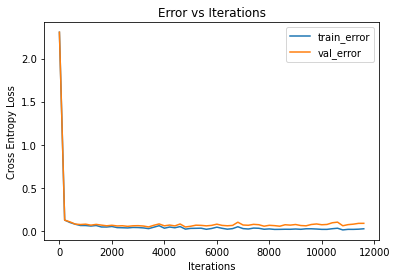

In [19]:
plt.plot([200*i for i in range(len(train_error))],train_error,label='train_error')
plt.plot([200*i for i in range(len(train_error))],val_error,label='val_error')
plt.xlabel('Iterations')
plt.ylabel('Cross Entropy Loss')
plt.title('Error vs Iterations')
plt.legend()
plt.show()

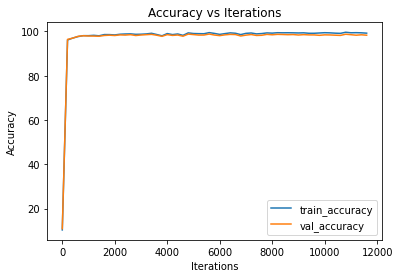

In [20]:
plt.plot([200*i for i in range(len(train_error))],train_accuracy,label='train_accuracy')
plt.plot([200*i for i in range(len(train_error))],val_accuracy,label='val_accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Iterations')
plt.legend()
plt.show()

In [21]:
[_,test_accuracy]=eval(model,torch.tensor(X_test,dtype=torch.float32).to(device),torch.tensor(y_test,dtype=torch.float32).to(device),criterion)
print(f' The average test accuracy after training is {test_accuracy}')

 The average test accuracy after training is 98.22


In [22]:
with torch.no_grad():
      y_pred_test=model(torch.tensor(X_test,dtype=torch.float32).to(device))

In [23]:
y_pred_test=y_pred_test.cpu().numpy()

In [24]:
y_pred_test[5]

array([ -9.232052 ,   7.656166 ,  -7.2495503, -11.855656 ,  -7.058545 ,
        -9.620799 ,  -6.6192126,  -2.2834585,  -3.7376332, -10.33713  ],
      dtype=float32)

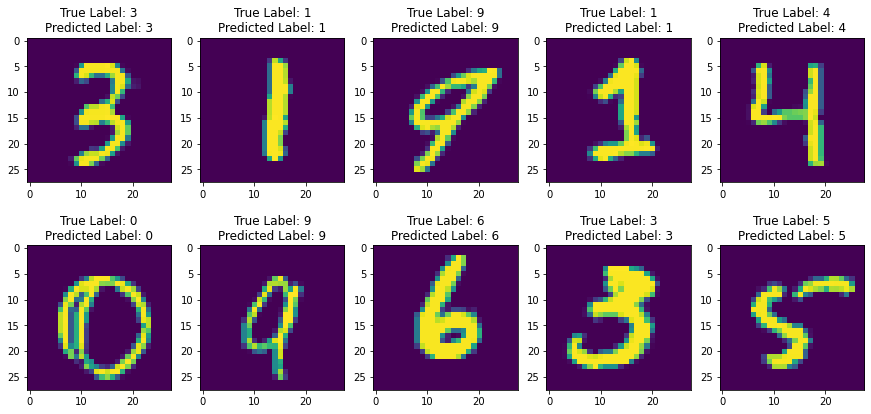

In [25]:
indices=np.random.randint(0,X_test.shape[0],10)
fig,axs=plt.subplots(2,5,figsize=(15,7))
k=0
for i in range(2):
  for j in range(5):
    true_label=np.argmax(y_test[indices[k]])
    predicted_label=np.argmax(y_pred_test[indices[k]])
    axs[i,j].imshow(X_test[indices[k]][0])
    axs[i,j].set_title(f'True Label: {true_label}\nPredicted Label: {predicted_label}')
    k+=1


plt.show()

In [26]:
def feature_map(input_shape,kernel,padding,stride,num_channels):
    H1=(input_shape[2]-kernel+2*padding)/stride+1
    H2=(input_shape[3]-kernel+2*padding)/stride+1
    return [[input_shape[0],num_channels,int(H1),int(H2)],input_shape[0]*num_channels*int(H1)*int(H2)]

def pool_map(input_shape,kernel,padding,stride):
    H1=(input_shape[2]-kernel+2*padding)/stride+1
    H2=(input_shape[3]-kernel+2*padding)/stride+1
    return [input_shape[0],input_shape[1],int(H1),int(H2)]

In [74]:
print(f'The dimensions of input to Conv1 are:{X_train[:batch_size].shape}')
conv1_out=feature_map(X_train[:batch_size].shape,3,1,1,32)
print(f'T1he dimensions of output to Conv1  are: {conv1_out[0]}')
print('\n')
print(f'The dimensions of input to maxpool1  are: {conv1_out[0]}')
mp1_out=pool_map(conv1_out[0],2,0,2)
print(f'The dimensions of output from maxpool2 are: {mp1_out}')
print('\n')
print(f'The dimensions of input to conv2  are: {mp1_out}')
conv2_out=feature_map(mp1_out,3,1,1,32)
print(f'The dimensions of output from conv2 are: {conv2_out[0]}')
print('\n')
print(f'The dimensions of input to maxpool2  are: {conv2_out[0]}')
mp2_out=pool_map(conv2_out[0],2,0,2)
print(f'The dimensions of output from conv2 are: {mp2_out}')

print('\n')
print(f'The dimensions of input to fc1  are: {mp2_out}')
print(f'The dimensions of output from fc1 are: [{batch_size},{model.fc1_neurons}]')

print('\n')
print(f'The dimensions of input to output layer  are: [{batch_size},{model.fc1_neurons}]')
print(f'The dimensions of output from output layer are:[{batch_size},{model.fc2_neurons}]')







The dimensions of input to Conv1 are:(64, 1, 28, 28)
The dimensions of output to Conv1  are: [64, 32, 28, 28]


The dimensions of input to maxpool1  are: [64, 32, 28, 28]
The dimensions of output from maxpool2 are: [64, 32, 14, 14]


The dimensions of input to conv2  are: [64, 32, 14, 14]
The dimensions of output from conv2 are: [64, 32, 14, 14]


The dimensions of input to maxpool2  are: [64, 32, 14, 14]
The dimensions of output from conv2 are: [64, 32, 7, 7]


The dimensions of input to fc1  are: [64, 32, 7, 7]
The dimensions of output from fc1 are: [64,500]


The dimensions of input to output layer  are: [64,500]
The dimensions of output from output layer are:[64,10]


In [28]:
conv_para=model.conv1.weight.detach().numpy().reshape(-1).shape[0]+model.conv1.bias.detach().numpy().reshape(-1).shape[0]+model.conv2.weight.detach().numpy().reshape(-1).shape[0]+model.conv2.bias.detach().numpy().reshape(-1).shape[0]
fc_para=model.fc1.weight.detach().numpy().reshape(-1).shape[0]+model.fc1.bias.detach().numpy().reshape(-1).shape[0]+model.fc2.weight.detach().numpy().reshape(-1).shape[0]+model.fc2.bias.detach().numpy().reshape(-1).shape[0]
print(f'The number of parameters in Convolutional Layers: {conv_para}')
print(f'The number of parameters in FC Layers: {fc_para}')
print(f'The total number of parameters :{conv_para+fc_para}')



The number of parameters in Convolutional Layers: 9568
The number of parameters in FC Layers: 789510
The total number of parameters :799078


In [29]:
conv_neurons=conv1_out[1]+conv2_out[1]
fc_neurons=model.fc1_neurons+model.fc2_neurons
print(f'The number of neurons in Convolutional Layers: {conv_neurons}')
print(f'The number of neurons in FC Layers: {fc_neurons}')
print(f'The total number of neurons :{conv_neurons+fc_neurons}')

The number of neurons in Convolutional Layers: 2007040
The number of neurons in FC Layers: 510
The total number of neurons :2007550


In [30]:
class MyConvNet_2(nn.Module):
    def __init__(self,input_channel=1,num_channels=32,conv_stride=1,conv_padding=1,conv_kernel=(3,3),pool_stride=2,pool_pad=0,pool_kernel=(2,2),fc1_neurons=500,fc2_neurons=10,device='cpu'):
        super(MyConvNet_2,self).__init__()
        self.conv1=nn.Conv2d(in_channels=input_channel,out_channels=num_channels,kernel_size=conv_kernel,stride=conv_stride,padding=conv_padding)
        self.bn1=nn.BatchNorm2d(num_channels)
        self.relu1=nn.ReLU()
        self.max_pool1=nn.MaxPool2d(kernel_size=pool_kernel,stride=pool_stride,padding=pool_pad)
        self.conv2=nn.Conv2d(in_channels=num_channels,out_channels=num_channels,kernel_size=conv_kernel,stride=conv_stride,padding=conv_padding)
        self.bn2=nn.BatchNorm2d(num_channels)
        self.relu2=nn.ReLU()
        self.max_pool2=nn.MaxPool2d(kernel_size=pool_kernel,stride=pool_stride,padding=pool_pad)
        self.fc1_neurons=fc1_neurons
        self.fc1=None
        self.bn3=nn.BatchNorm1d(fc1_neurons)
        self.relu3=nn.ReLU()
        self.fc2=nn.Linear(fc1_neurons,fc2_neurons)
        self.sm=nn.Softmax(dim=1)
    def forward(self,x):
        out1=self.relu1(self.conv1(x)).to(device)
        out1_1=self.max_pool1(out1).to(device)
        out2=self.relu2(self.conv2(out1_1)).to(device)
        out2_1=self.max_pool2(out2).to(device)
        if self.fc1  is None:
            self.fc1=nn.Linear(torch.flatten(out2_1,1).shape[1],self.fc1_neurons).to(device)
            #self.fc1=self.bn3(self.fc1)
        #print(self.fc1.weight.device)
        #print(torch.flatten(out2_1,1).device)

        out3=self.relu3(self.bn3(self.fc1(torch.flatten(out2_1,1)).to(device)))
        out4=self.fc2(out3).to(device)
        softmax_out=self.sm(out4).to(device)

        return out4




In [31]:
batch_size = 64
learning_rate = 0.01
num_epochs = 15
print(device)
model_2 = MyConvNet_2(device=device).to(device)
criterion = nn.CrossEntropyLoss()
print(model_2.parameters())
optimizer = optim.Adam(model_2.parameters(), lr=learning_rate)


[model_2,train_error_bn,val_error_bn,train_accuracy_bn,val_accuracy_bn]=train_model(model_2, X_train[:50000],y_train[:50000], X_train[50000:],y_train[50000:],criterion, optimizer, num_epochs=num_epochs, device=device)

cpu
<generator object Module.parameters at 0x000001ED06743C30>
Epoch [1/15], Loss: 0.1648
Epoch [2/15], Loss: 0.0697
Epoch [3/15], Loss: 0.0542
Epoch [4/15], Loss: 0.0503
Epoch [5/15], Loss: 0.0503
Epoch [6/15], Loss: 0.0437
Epoch [7/15], Loss: 0.0393
Epoch [8/15], Loss: 0.0412
Epoch [9/15], Loss: 0.0390
Epoch [10/15], Loss: 0.0384
Epoch [11/15], Loss: 0.0318
Epoch [12/15], Loss: 0.0361
Epoch [13/15], Loss: 0.0372
Epoch [14/15], Loss: 0.0290
Epoch [15/15], Loss: 0.0372
Training complete.


In [32]:
[_,test_accuracy2]=eval(model_2,torch.tensor(X_test,dtype=torch.float32).to(device),torch.tensor(y_test,dtype=torch.float32).to(device),criterion)
print(f' The average test accuracy after training with batch normalisation is {test_accuracy2}')

 The average test accuracy after training with batch normalisation is 98.33


1. Training time is observed to increase with the introduction of batch normalisation to hidden layers.
2. Test Accuracy marginally increased to 98.33 from 98.21

___

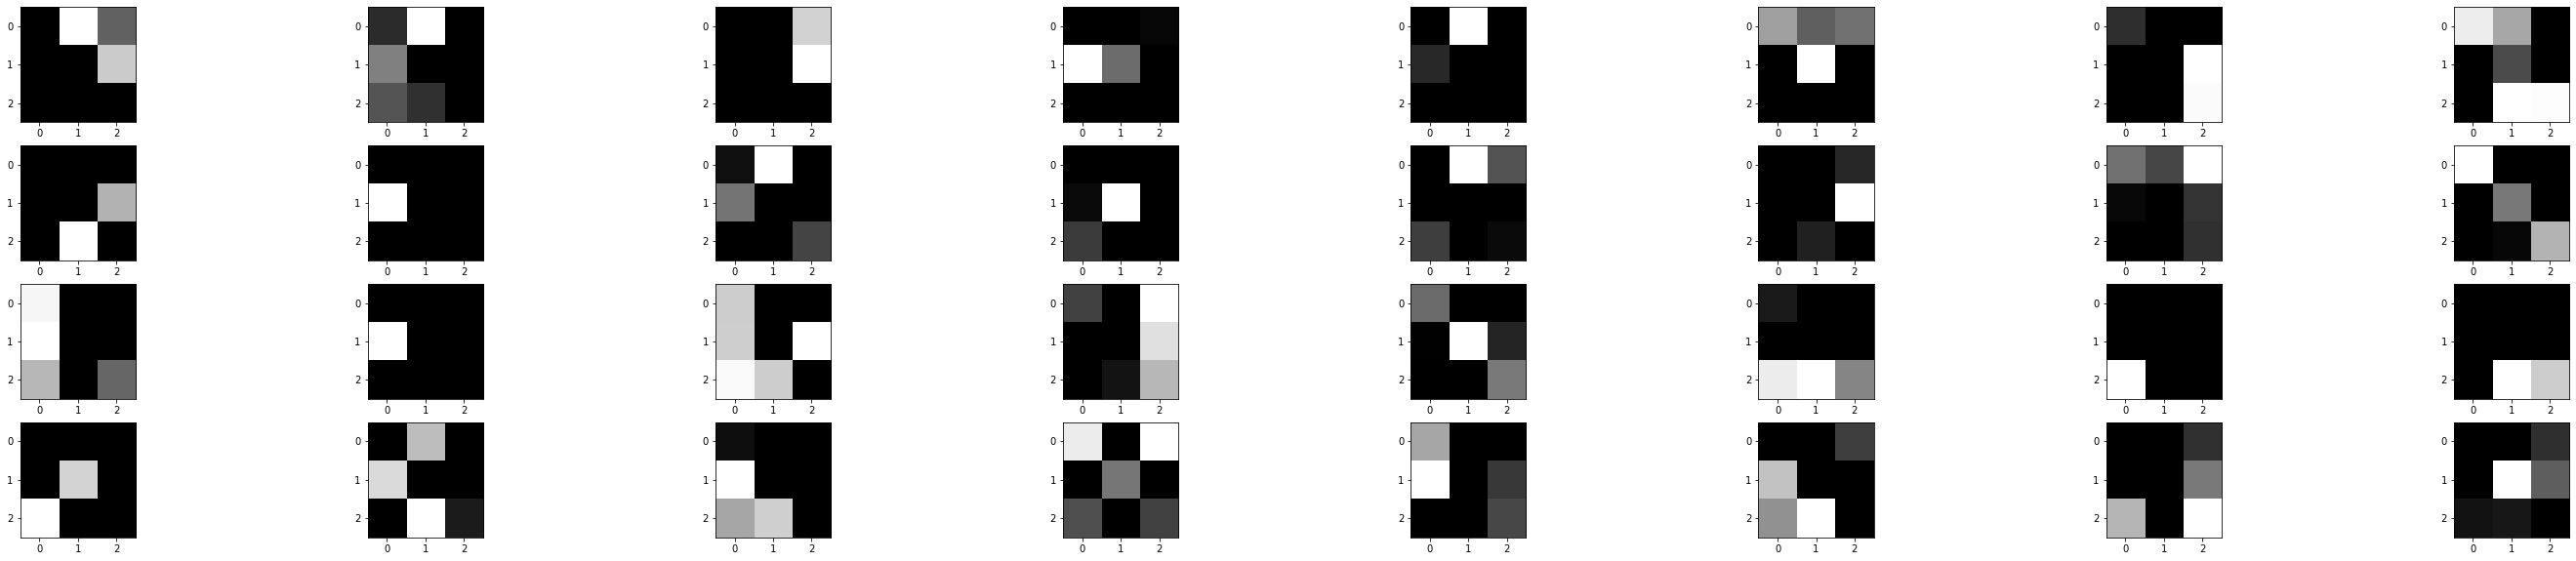

In [33]:
fig,axs=plt.subplots(4,8,figsize=(50,10))
k=0
for i in range(4):
    for j in range(8):
        filters=model.conv1.weight.detach().numpy()

        filters=filters[k,0].reshape(3,3)
        #print(filters.shape)
        #filters = (filters - filters.min()) / (filters.max() - filters.min())
        filters = np.maximum(filters, 0)
        axs[i][j].imshow(filters,cmap='gray')
        k+=1



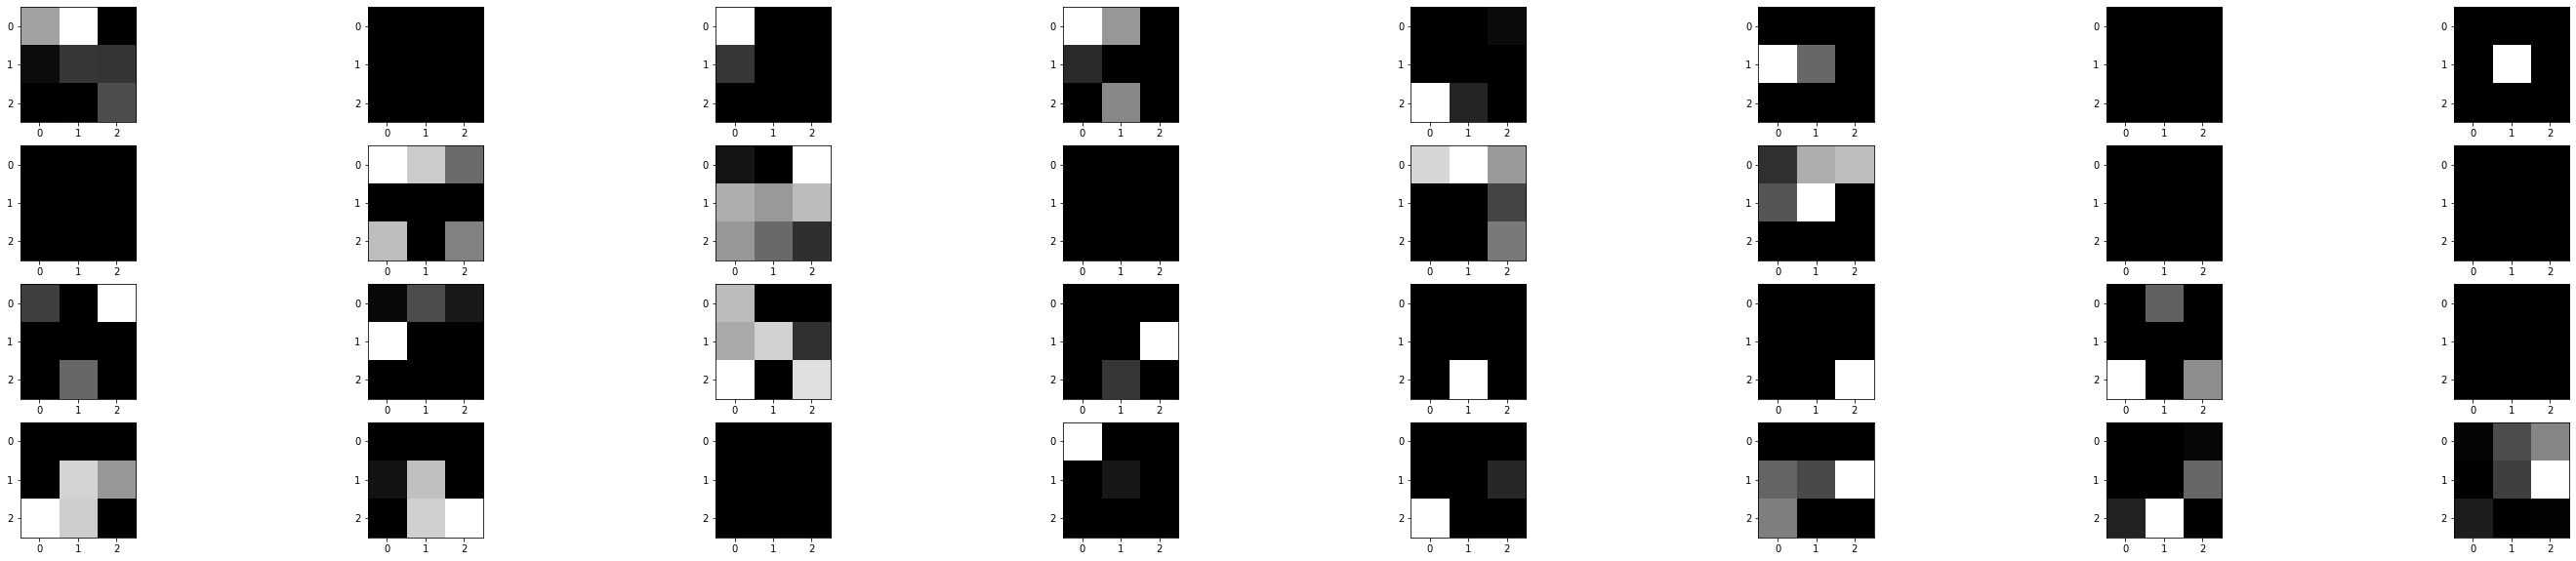

In [75]:
fig,axs=plt.subplots(4,8,figsize=(50,10))
k=0
for i in range(4):
    for j in range(8):
        filters=model.conv2.weight.detach().numpy()

        filters=filters[k,2].reshape(3,3)
        #print(filters.shape)
        #filters = (filters - filters.min()) / (filters.max() - filters.min())
        filters = np.maximum(filters, 0)
        axs[i][j].imshow(filters,cmap='gray')
        k+=1



1. The filters from Conv1 layer are more representative of an edge detector.
2. The filters from Conv2 are dark at many regions and seem to take white values only at few pixels indicating it is capturing more nuanced high level details.

In [35]:
x = torch.tensor(X_train[0:1, :, :, :], dtype=torch.float32).to(device)  
feature_maps=[]
for layer in model.children():
    if isinstance(layer, torch.nn.Conv2d): 
        x = layer(x) 
        feature_maps.append(x)
    elif isinstance(layer, torch.nn.Linear):  
        break 

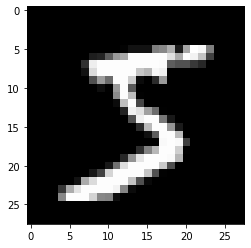

In [36]:
plt.imshow(X_train[0,0],cmap='gray')

Text(0.5, 0.98, 'Conv1 Filter maps')

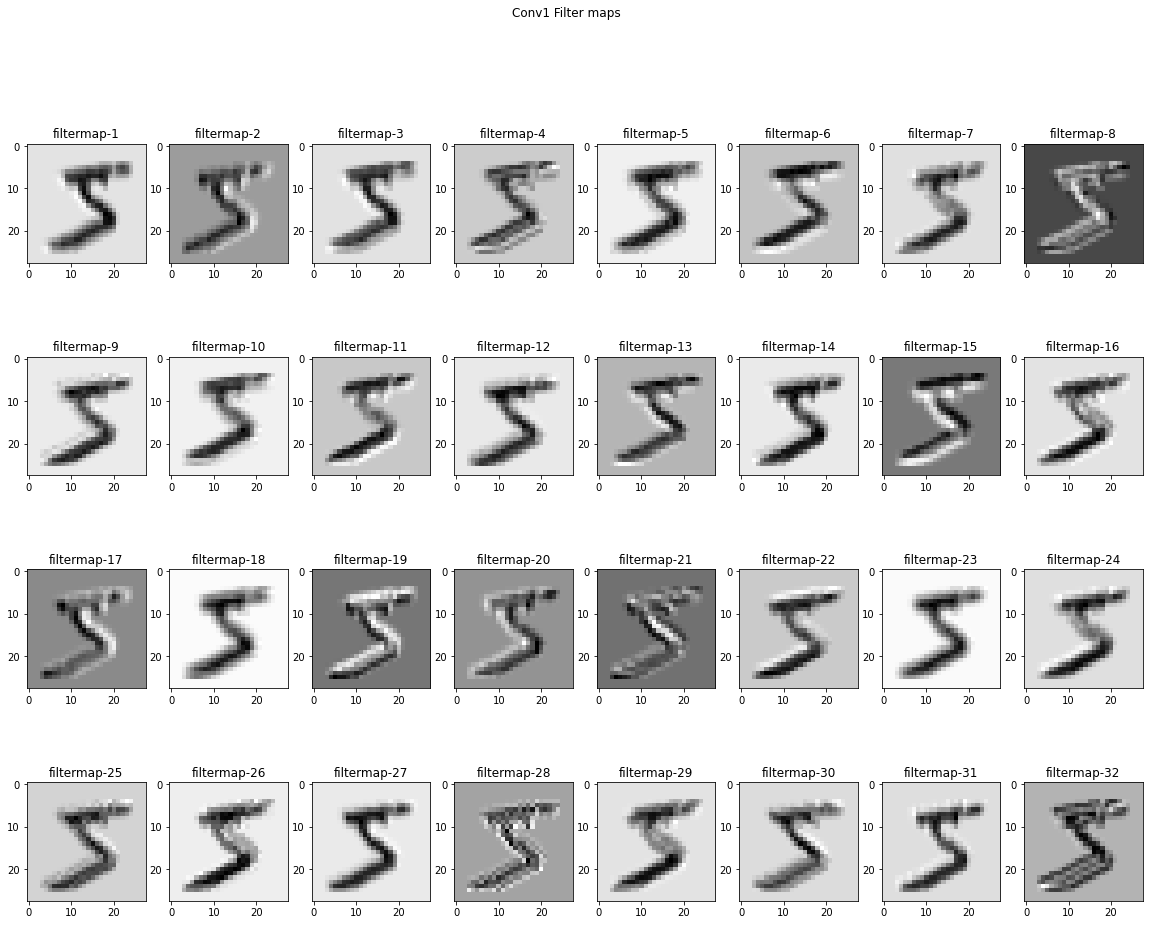

In [37]:
k=0
fig,axs=plt.subplots(4,8,figsize=(20,15))
for i in range(4):
    for j in range(8):
        axs[i][j].imshow(feature_maps[0][0,k].detach().cpu().numpy(),cmap='gray')
        axs[i][j].set_title(f'filtermap-{k+1}')
        k+=1
plt.suptitle('Conv1 Filter maps')

Text(0.5, 0.98, 'Conv2 Filter maps')

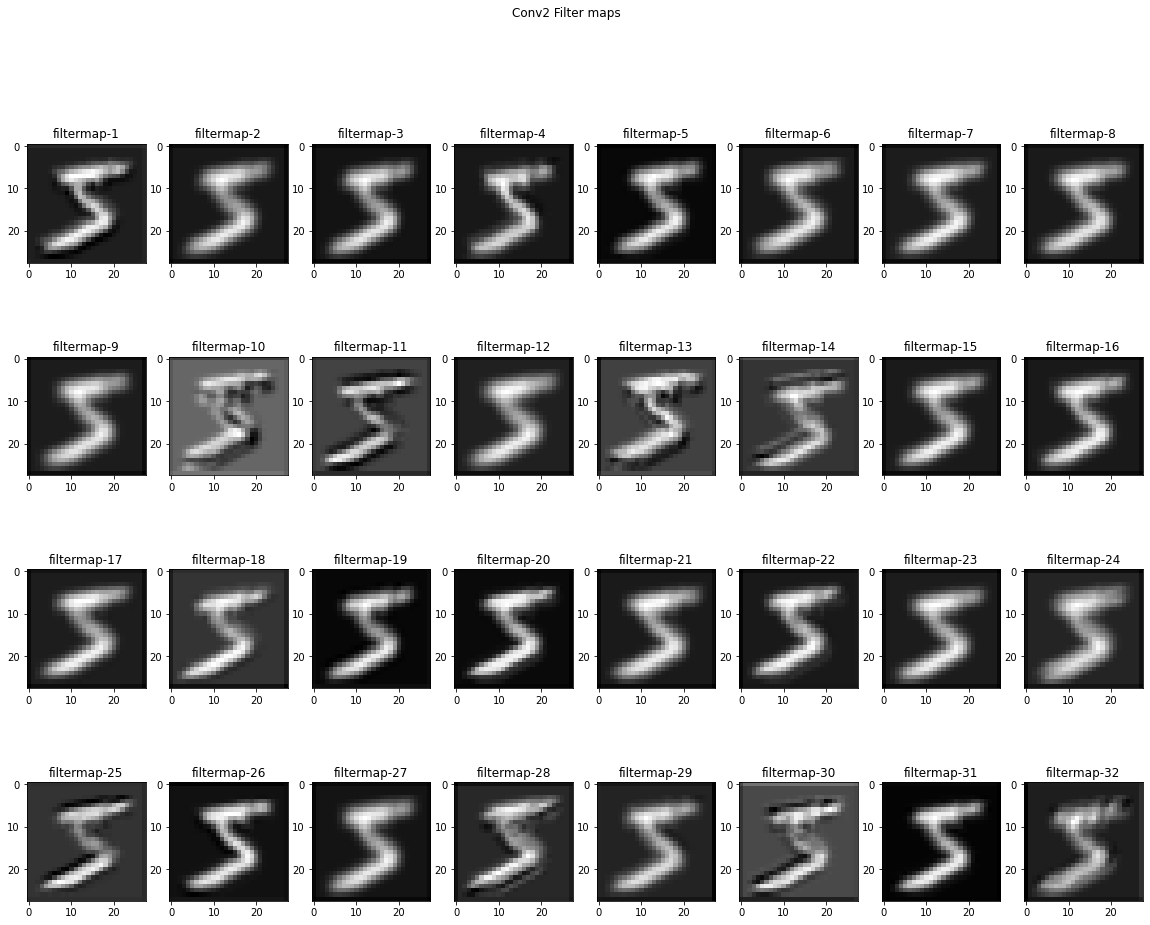

In [38]:
k=0
fig,axs=plt.subplots(4,8,figsize=(20,15))
for i in range(4):
    for j in range(8):
        axs[i][j].imshow(feature_maps[1][0,k].detach().cpu().numpy(),cmap='gray')
        axs[i][j].set_title(f'filtermap-{k+1}')
        k+=1
plt.suptitle('Conv2 Filter maps')

# Comments

1. The filter maps from convolutional layer 1 is more indicative of the input convolved over a low pass filter where the high feequency bands represented by the pixels containing the digits have a zero value in the filter map obtained. 
2. The filter maps from convolutional layer 2 indicates results from a high pass filter where the low fequency background has turned to zero again and the high frequency pixels containing the digit are nearly white

In [39]:
np.mean(X_train[0][0].reshape(-1))

0.13768007202881152

# Occlusion experiment

In [40]:
np.argmax(y_test[0])==np.argmax(y_pred_test[0])
np.argmax(y_pred_test[8])

5

In [41]:
index=2
X=X_test[index:index+1,0:1]
print(X.shape)
occ_size=4
occ_map=np.zeros((X.shape[2],X.shape[3]))
for i in range(0,X.shape[2]-occ_size+1,occ_size):
    for j in range(0,X.shape[3]-occ_size+1,occ_size):
        X_temp=X.copy()
        X_temp[0,0,i:i+occ_size,j:j+occ_size]=1
        #print(X_temp[0][0][i:i+occ_size,j:j+occ_size].shape)
        with torch.no_grad():
            y_pred_temp=model(torch.tensor(X_temp,dtype=torch.float32).to(device))
        prob=np.exp(y_pred_temp.cpu().numpy().reshape(-1))/np.sum(np.exp(y_pred_temp.cpu().numpy().reshape(-1)))
        #print(prob[1])
        occ_map[i:i+occ_size,j:j+occ_size]=prob[(np.argmax(y_pred_test[index]))]
        #print(occ_map[i:i+occ_size,j:j+occ_size])
        
        
            
        
        

(1, 1, 28, 28)


Text(0.5, 1.0, 'Original Image')

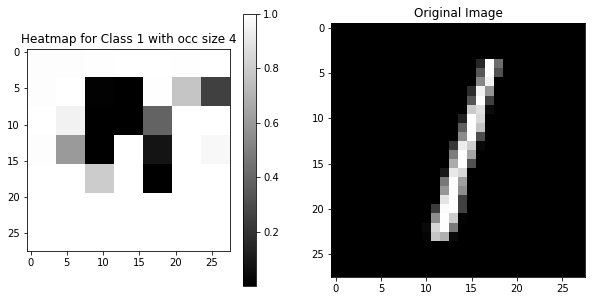

In [42]:
fig,axs=plt.subplots(1,2,figsize=(10,5))
im=axs[0].imshow(occ_map,cmap='gray')
fig.colorbar(im,ax=axs[0])
axs[0].set_title(f'Heatmap for Class {np.argmax(y_pred_test[index])} with occ size 4')
axs[1].imshow(X_test[index][0],cmap='gray')
axs[1].set_title('Original Image')
#occ_map

1. The occlusion seems to affect many pixels that are part of the digit as well as some pixels that are black.
2. Overall, we can say that learning is meaningful as it does seem to take to be maximally impacted when pixels carrying the digit are occluded.


# Section 3
___

**non-targeted attack**

In [90]:
def update_input(model, X,target_class, num_epochs=10, device='cpu'):
    
    X=torch.tensor(X,requires_grad=True,device=device,dtype=torch.float32)
    #X=X.to(torch.float32)
    updates=0
    losses=[]
    for epoch in range(num_epochs):
            running_loss = 0.0

            updates+=1
            #optimizer.zero_grad()

            # Forward pass
            outputs = model(X)
            #print(outputs)
            loss = outputs[0,target_class]
            c=loss.detach().numpy()
            losses.append(c)
            #print(loss)
            # Backward pass and optimize
            loss.backward()
            #print(X.grad.shape)
            with torch.no_grad():
                X=X+0.01*X.grad
            #print(X.grad)
            
            running_loss += loss.item()
            X=X.clone().detach().requires_grad_(True)
            #X.grad.zero_()
    #X=torch.clamp(X,0,1)

    return losses,X.detach().cpu().numpy()



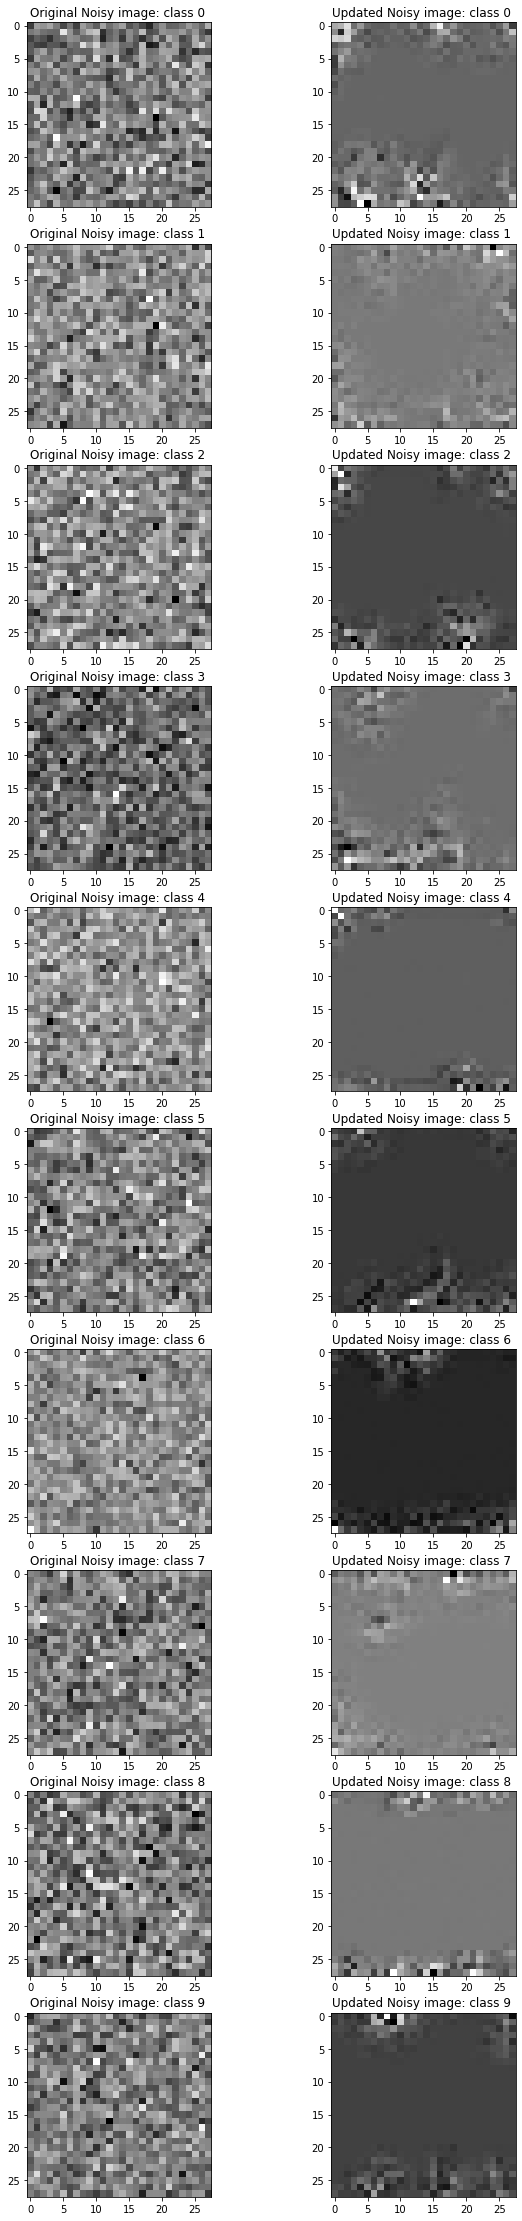

In [91]:
k=0
fig,axs=plt.subplots(10,2,figsize=(10,40))
for i in range(10):
        #for j in range(2):
        X_noise=np.random.normal(128,1,(1,1,X.shape[2],X.shape[3]))
        _,X_out=update_input(model, X_noise/255,i, num_epochs=500, device='cpu')
        axs[i][0].imshow(X_noise[0][0],cmap='gray')
        axs[i][0].set_title(f'Original Noisy image: class {i} ')
        axs[i][1].imshow(X_out[0][0],cmap='gray')
        axs[i][1].set_title(f'Updated Noisy image: class {i} ')



In [45]:
X_noise=np.random.normal(0.5,0.1,(1,1,X.shape[2],X.shape[3]))
losses,X_out=update_input(model, X_noise,3, num_epochs=1000, device='cpu')
X_out=torch.tensor(X_out,requires_grad=True,device=device,dtype=torch.float32)
model(X_out)

tensor([[-5299.7573, -1766.8486, -2152.7336,  8808.6611, -4916.4170, -1633.2639,
         -4188.0542, -1595.3666, -4631.6655, -3936.2537]],
       grad_fn=<AddmmBackward0>)

Text(0.5, 1.0, 'Target Class: 3')

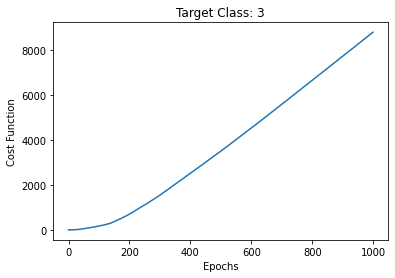

In [46]:
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Cost Function')
plt.title('Target Class: 3')

In [78]:
for i in range(5):
    X_noise=np.random.normal(0.5,0.1,(1,1,X.shape[2],X.shape[3]))
    losses,X_out=update_input(model, X_noise,3, num_epochs=1000, device='cpu')
    X_out=torch.tensor(X_out,requires_grad=True,device=device,dtype=torch.float32)
    print(torch.argmax(model(X_out)))

tensor(3)
tensor(3)
tensor(3)
tensor(3)
tensor(3)


1. In the non targeted attack experiment, the generated image also looked random and did not resemble the target class.
2. The model is indeed predicted the target class with high confidence for the generated images.
3. The cost function is increasing

**Targeted-Attack**

In [67]:
def update_input_target(model, X,target_class,target_image, num_epochs=10,beta=0.001, device='cpu'):
    
    X=torch.tensor(X,requires_grad=True,device=device,dtype=torch.float32)
    target_image=torch.tensor(target_image,device=device,dtype=torch.float32)
    #X=X.to(torch.float32)
    updates=0
    losses=[]
    for epoch in range(num_epochs):
            running_loss = 0.0

            updates+=1
            #optimizer.zero_grad()

            # Forward pass
            outputs = model(X)
            #print(outputs)
            loss = outputs[0,target_class]-beta*torch.sum(torch.square(X-target_image))
            #print(loss)
            c=loss.detach().numpy()
            losses.append(c)
            #print(loss)
            # Backward pass and optimize
            loss.backward()
            #print(X.grad.shape)
            with torch.no_grad():
                X=X+0.0001*X.grad
            #print(X.grad)
            
            running_loss += loss.item()
            X=X.clone().detach().requires_grad_(True)
            #X.grad.zero_()
    X=torch.clamp(X,0,1)

    return losses,X.detach().cpu().numpy()



**Keeping the target image fixed as 2 while varying the target class from 0 to 9**

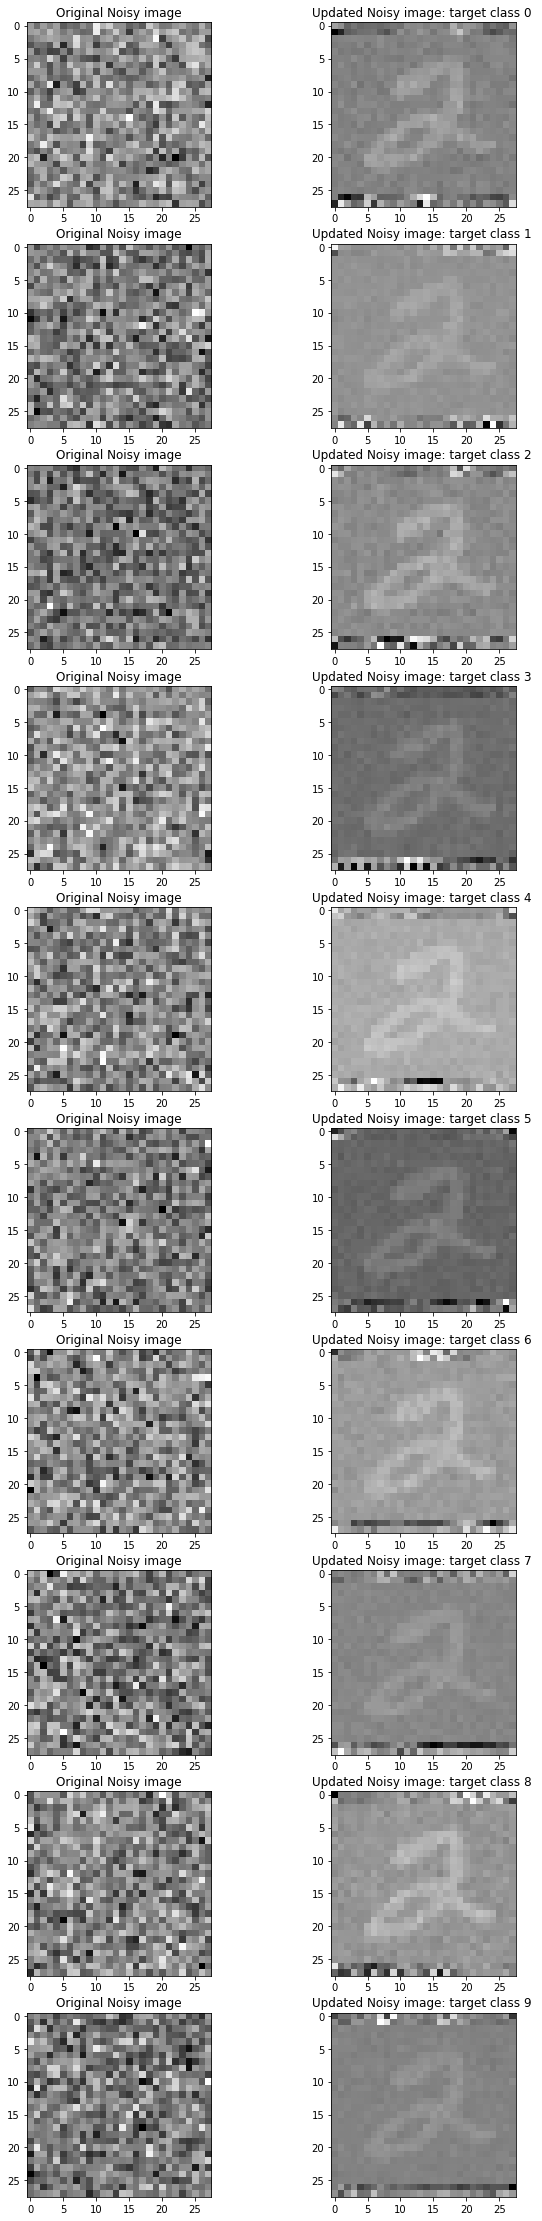

In [88]:
k=0
X_t=X_train[np.argmax(y_train,axis=1)==2][0:1,0:1]

fig,axs=plt.subplots(10,2,figsize=(10,40))
for i in range(10):
        #for j in range(2):
        X_n=np.random.normal(128,1,(1,1,X_t.shape[2],X_t.shape[3]))
        losses,X_out=update_input_target(model, X_n/255,i,X_t, num_epochs=1000,beta=0.1, device='cpu')

        axs[i][0].imshow(X_n[0][0],cmap='gray')
        axs[i][0].set_title(f'Original Noisy image')
        axs[i][1].imshow(X_out[0][0],cmap='gray')
        axs[i][1].set_title(f'Updated Noisy image: target class {i} ')



**Keeping the target class fixed as 5 while varying the target image from 0 to 9**

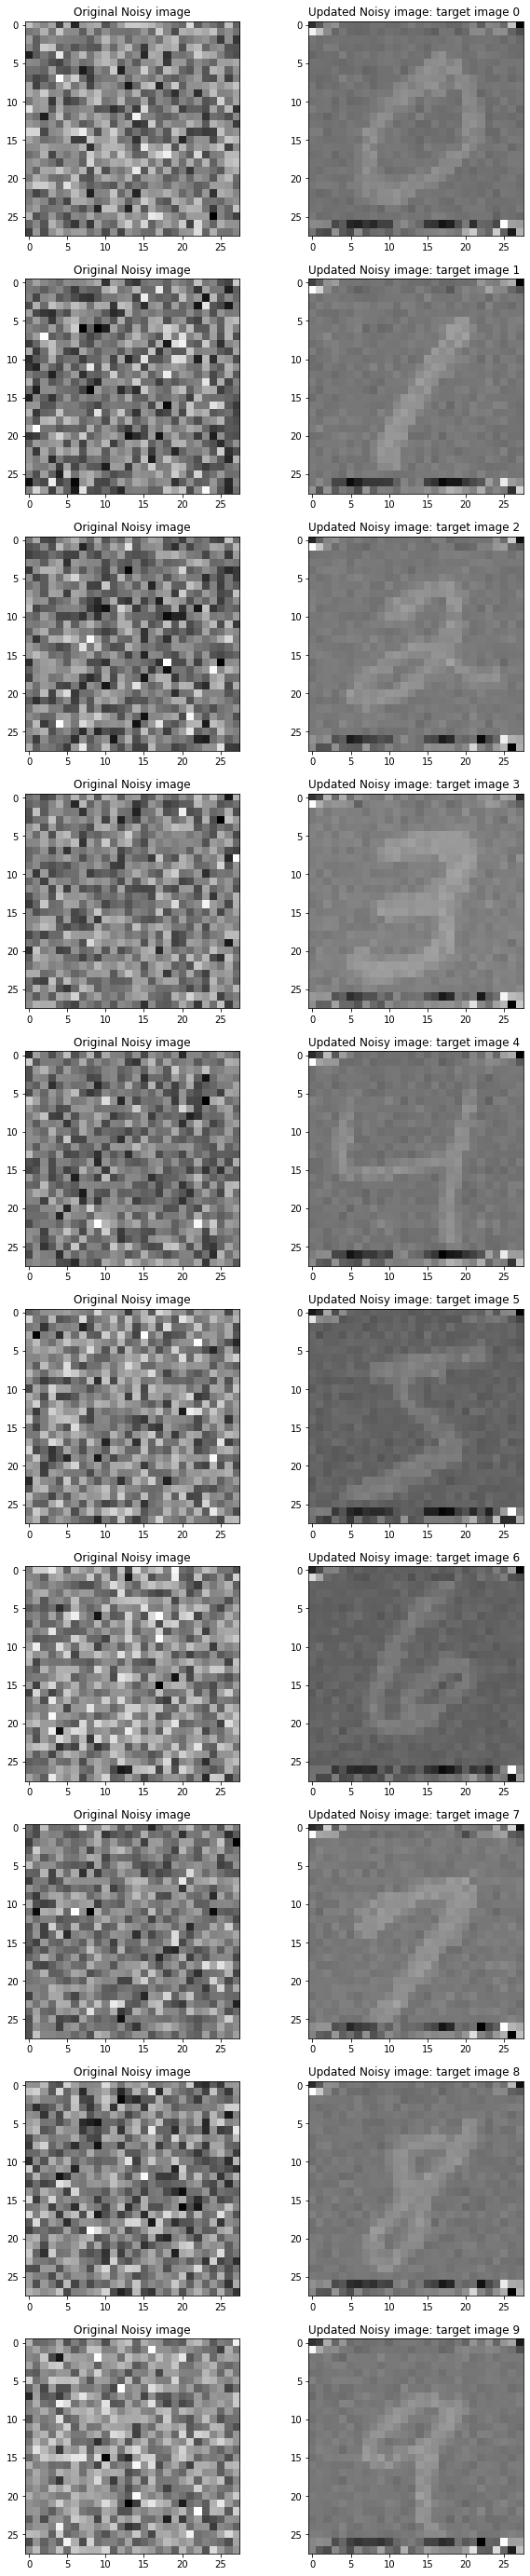

In [89]:
k=0


fig,axs=plt.subplots(10,2,figsize=(10,50))
for i in range(10):
        #for j in range(2):
        X_t=X_train[np.argmax(y_train,axis=1)==i][0:1,0:1]
        X_n=np.random.normal(128,1,(1,1,X_t.shape[2],X_t.shape[3]))
        losses,X_out=update_input_target(model, X_n/255,5,X_t, num_epochs=1000,beta=0.1, device='cpu')

        axs[i][0].imshow(X_n[0][0],cmap='gray')
        axs[i][0].set_title(f'Original Noisy image')
        axs[i][1].imshow(X_out[0][0],cmap='gray')
        axs[i][1].set_title(f'Updated Noisy image: target image {i} ')



# Comments:
1. The generated image resembles the digit in target image.
2. However the logit score is maximised for the target class. 